1) Escolher Tema/Problema de negócio de TAREFA Supervisionada (Regressão, Classificação, PLN)

2) Escolher Tema/Problema de negócio de TAREFA Não supervisionada (Agrupamento, Regras de Associação, Detecção de Anomalias, Segmentação de Imagens, Rotulagem em problema semisupervisionado etc.)

--------------

Cada Tarefa deverá justificar a escolha de algoritmo, descrever o problema (introdução) explicitando variáveis alvo, variáveis e features usadas, transformação de variáveis, pipelines etc.

Considere usar o Cookie Cutter para organizar as pastas do projeto

Considerem bases disponíveis de dados, ou mesmo a obtenção/criação de datasets para seu problema.

Usar métricas apropriadas para julgar os modelos.

Implementem UI para consumo do modelo e output para o user.

# **COLUNAS**
**ID** - ID do Paciente

**A1_Score** to A10_Score - Pontuação baseada no espectro do autismo

**age** - Idade em anos

**gender** - Genero

**ethnicity** - Etnia

**jaundice** - Se o paciente tinha icterícia no momento do nascimento

**autism** - Se algum familiar tem autismo

**contry_of_res** - País do paciente

**used_app_before** - Se o paciente foi submetido a um teste de triagem antes

**result** - Pontuação para teste de triagem AQ1-10

**age_desc** - Idade do paciente

**relation** - Relação do paciente que completou o teste

**Class/ASD** - Resultado classificado como 0 ou 1. 0 representa Não e 1 representa Sim. Esta é a coluna de traget.

In [24]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


In [25]:
df_train = pd.read_csv("http://raw.githubusercontent.com/Erickhbs/III-ml/refs/heads/main/data/train.csv")
df_test = pd.read_csv("http://raw.githubusercontent.com/Erickhbs/III-ml/refs/heads/main/data/test.csv")

df_train = df_train.drop(columns=['contry_of_res', 'ID', 'age_desc','gender','jaundice', 'relation','used_app_before', 'age'], axis=1)
df_test = df_test.drop(columns=['contry_of_res', 'ID', 'age_desc','gender','jaundice', 'relation','used_app_before', 'age', ], axis=1)


In [26]:
df_train.loc[df_train["ethnicity"].isin({"Pasifika", "Hispanic", "Turkish"}), "ethnicity"] = "Others"
df_test.loc[df_test["ethnicity"].isin({"Pasifika", "Hispanic", "Turkish"}), "ethnicity"] = "Others"

le = preprocessing.LabelEncoder()
df_train['ethnicity'] = le.fit_transform(df_train['ethnicity'])
df_test['ethnicity'] = le.transform(df_test['ethnicity'])
df_train['austim'] = le.fit_transform(df_train['austim'])
df_test['austim'] = le.transform(df_test['austim'])

print(df_train)

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0           1         0         1         0         1         0         1   
1           0         0         0         0         0         0         0   
2           1         1         1         1         1         1         1   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
795         0         1         0         0         0         0         0   
796         0         1         1         0         0         1         0   
797         0         0         0         0         0         0         0   
798         0         0         0         0         0         0         0   
799         0         1         0         0         0         0         0   

     A8_Score  A9_Score  A10_Score  ethnicity  austim     result  Class/ASD

In [27]:
# Definir variáveis de entrada e variável alvo
y = df_train['Class/ASD']
X = df_train[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
              'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
              'austim', 'result', 'ethnicity']]

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [28]:
# Avaliar o número ideal de clusters usando a pontuação de silhueta
silhouette_scores = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores[k] = silhouette_avg

best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f'Melhor número de clusters com base na pontuação de silhueta: {best_k}')

# Aplicar K-Means com o número ideal de clusters
kmeans = KMeans(n_clusters=best_k, random_state=0)
df_train['cluster'] = kmeans.fit_predict(X_scaled)

# Comparar clusters com a variável alvo
comparison_df = pd.DataFrame({'Cluster': df_train['cluster'], 'Target': y})
print(comparison_df.groupby(['Cluster', 'Target']).size())

Melhor número de clusters com base na pontuação de silhueta: 2
Cluster  Target
0        0         456
         1           8
1        0         183
         1         153
dtype: int64


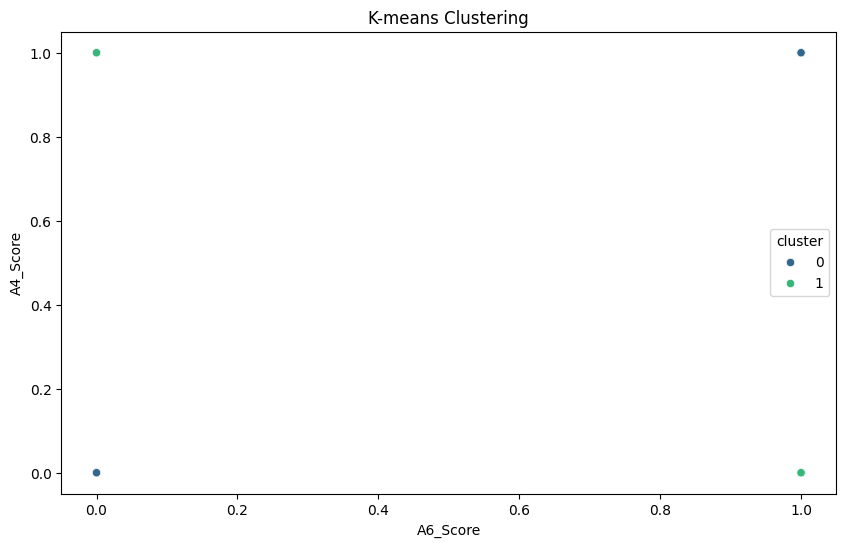

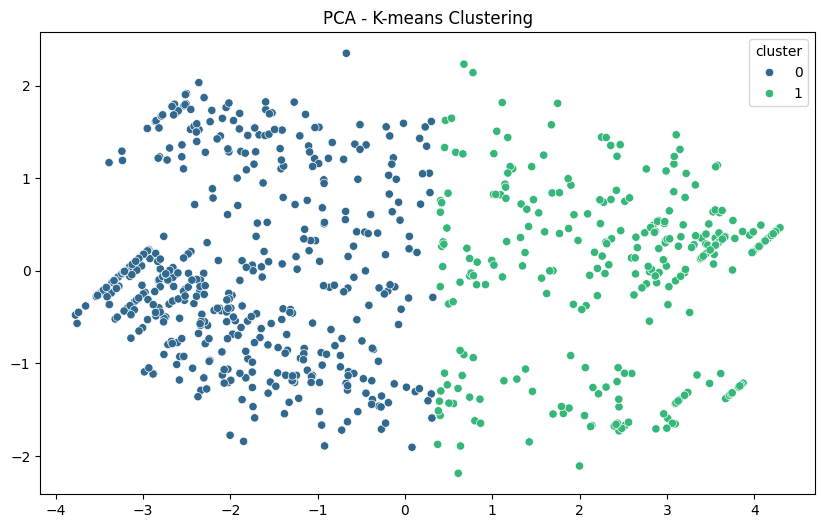

['kmeans_model.pkl']

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_train['A6_Score'], y=df_train['A4_Score'], hue=df_train['cluster'], palette='viridis')
plt.title("K-means Clustering")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_train['cluster'], palette='viridis')
plt.title("PCA - K-means Clustering")
plt.show()

joblib.dump(kmeans, 'kmeans_model.pkl')